In [1]:
import tqdm
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, latent_dim)
        self.fc3 = nn.Linear(256, latent_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        mean = self.fc2(x)
        log_var = self.fc3(x)
        return mean, log_var

In [4]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))    
        return x

In [5]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)
        
    def forward(self, x):
        mean, log_var = self.encoder(x)

        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = eps.mul(std).add_(mean)
        
        x = self.decoder(z)
        return x, mean, log_var

In [6]:
def loss_fn(x, gen_x, mean, log_var):
    bce = F.binary_cross_entropy(gen_x, x, size_average=False)
    kld = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return bce + kld

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 51
batch_size = 64
input_dim = 28 * 28
latent_dim = 2
lr = 1e-3
transform = transforms.Compose([transforms.ToTensor()])
z = torch.randn(64, latent_dim).to(device)

In [8]:
device

device(type='cuda')

In [9]:
train_dataset = datasets.MNIST('data/', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data/', train=False, download=True, transform=transform)

In [10]:
train_batches = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_batches = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

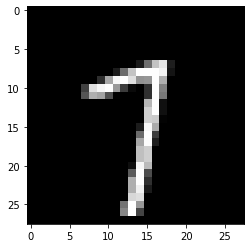

In [11]:
img, _ = train_dataset[42]
plt.imshow(img[0], cmap="gray")

In [12]:
def save_fake_images(epoch):
    with torch.no_grad():
        fake = net.decoder(z)
        
    fake = fake.cpu().view(-1, 1, 28, 28)
    img_grid = make_grid(fake)
    file_name = "fake_images-{0:0=4d}.png".format(epoch)
    save_image(fake, file_name, nrow=8)

    print("")
    print("Image Saved!")
    print("")

In [13]:
for x, _ in train_batches:
    img_grid = make_grid(x[:64])
    save_image(img_grid, "real_images.png", nrow=8)
    break

In [14]:
net = VAE(input_dim, latent_dim).to(device)
opt = torch.optim.Adam(net.parameters(), lr)
net

VAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=784, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=2, bias=True)
    (fc3): Linear(in_features=256, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=2, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=784, bias=True)
  )
)

In [15]:
def loop(net, batches, train):
    batch_losses = []

    if train:
        print("Train Loop:")
        print("")
        net.train()

        for x, _ in tqdm.tqdm(batches, total=len(batches)):
            x = x.view(-1, 28 * 28)
            x = x.to(device)

            gen_x, mean, log_var = net(x)
            loss = loss_fn(x, gen_x, mean, log_var)

            opt.zero_grad()
            loss.backward()
            opt.step()
            batch_losses.append(loss.item())

    else:
        print("Test Loop:")
        print("")
        net.eval()

        with torch.no_grad():
            for x, _ in tqdm.tqdm(batches, total=len(batches)):
                x = x.view(-1, 28 * 28)
                x = x.to(device)

                gen_x, mean, log_var = net(x)
                loss = loss_fn(x, gen_x, mean, log_var)
                batch_losses.append(loss.item())


    print("")
    print("")
    return sum(batch_losses) / len(batch_losses)

In [16]:
for epoch in range(epochs):
    train_loss = loop(net, train_batches, True)
    test_loss = loop(net, test_batches, False)

    if epoch % 10 == 0:
        save_fake_images(epoch)

    print(f"epoch: {epoch} | train_loss: {train_loss:.4f} | test_loss: {test_loss:.4f}")
    print("")

  1%|          | 6/938 [00:00<00:16, 55.60it/s]

Train Loop:



  8%|▊         | 12/157 [00:00<00:01, 113.01it/s]



Test Loop:



  1%|          | 7/938 [00:00<00:15, 61.98it/s]




Image Saved!

epoch: 0 | train_loss: 11772.5261 | test_loss: 10705.4632

Train Loop:



  8%|▊         | 12/157 [00:00<00:01, 113.12it/s]



Test Loop:



  1%|          | 8/938 [00:00<00:11, 78.42it/s]



epoch: 1 | train_loss: 10570.0190 | test_loss: 10420.8339

Train Loop:



  7%|▋         | 11/157 [00:00<00:01, 102.67it/s]



Test Loop:



  1%|          | 7/938 [00:00<00:15, 62.04it/s]



epoch: 2 | train_loss: 10374.9378 | test_loss: 10282.2446

Train Loop:



  6%|▌         | 9/157 [00:00<00:01, 86.83it/s]



Test Loop:



  1%|          | 8/938 [00:00<00:12, 76.76it/s]



epoch: 3 | train_loss: 10257.5942 | test_loss: 10183.8895

Train Loop:



  6%|▋         | 10/157 [00:00<00:01, 95.04it/s]



Test Loop:



  1%|          | 8/938 [00:00<00:12, 77.49it/s]



epoch: 4 | train_loss: 10162.9588 | test_loss: 10101.7529

Train Loop:



  6%|▋         | 10/157 [00:00<00:01, 95.00it/s]



Test Loop:



  1%|          | 8/938 [00:00<00:12, 74.79it/s]



epoch: 5 | train_loss: 10084.6697 | test_loss: 10043.2757

Train Loop:



  8%|▊         | 12/157 [00:00<00:01, 119.72it/s]



Test Loop:



  1%|          | 9/938 [00:00<00:11, 80.85it/s]



epoch: 6 | train_loss: 10017.4489 | test_loss: 9990.2526

Train Loop:



  6%|▋         | 10/157 [00:00<00:01, 94.05it/s]



Test Loop:



  1%|          | 8/938 [00:00<00:11, 79.38it/s]



epoch: 7 | train_loss: 9961.1812 | test_loss: 9946.3936

Train Loop:



  6%|▌         | 9/157 [00:00<00:01, 84.79it/s]



Test Loop:



  1%|          | 8/938 [00:00<00:12, 74.73it/s]



epoch: 8 | train_loss: 9912.2705 | test_loss: 9890.8742

Train Loop:



  8%|▊         | 12/157 [00:00<00:01, 112.11it/s]



Test Loop:



  1%|          | 6/938 [00:00<00:15, 59.39it/s]



epoch: 9 | train_loss: 9868.1242 | test_loss: 9849.1546

Train Loop:



  6%|▋         | 10/157 [00:00<00:01, 94.83it/s]



Test Loop:



  1%|          | 8/938 [00:00<00:11, 78.01it/s]




Image Saved!

epoch: 10 | train_loss: 9831.4275 | test_loss: 9816.4308

Train Loop:



  8%|▊         | 12/157 [00:00<00:01, 114.85it/s]



Test Loop:



  1%|          | 8/938 [00:00<00:12, 75.78it/s]



epoch: 11 | train_loss: 9798.7049 | test_loss: 9807.8031

Train Loop:



  8%|▊         | 12/157 [00:00<00:01, 116.72it/s]



Test Loop:



  1%|          | 8/938 [00:00<00:12, 74.18it/s]



epoch: 12 | train_loss: 9768.9114 | test_loss: 9767.8793

Train Loop:



  8%|▊         | 12/157 [00:00<00:01, 115.27it/s]



Test Loop:



  1%|          | 6/938 [00:00<00:16, 57.98it/s]



epoch: 13 | train_loss: 9739.2394 | test_loss: 9752.4516

Train Loop:



  7%|▋         | 11/157 [00:00<00:01, 106.35it/s]



Test Loop:



  1%|          | 7/938 [00:00<00:14, 62.20it/s]



epoch: 14 | train_loss: 9715.2238 | test_loss: 9731.7283

Train Loop:



  7%|▋         | 11/157 [00:00<00:01, 104.18it/s]



Test Loop:



  1%|          | 8/938 [00:00<00:12, 77.22it/s]



epoch: 15 | train_loss: 9691.6579 | test_loss: 9706.4285

Train Loop:



  8%|▊         | 12/157 [00:00<00:01, 114.26it/s]



Test Loop:



  1%|          | 7/938 [00:00<00:15, 61.73it/s]



epoch: 16 | train_loss: 9665.5332 | test_loss: 9680.2492

Train Loop:



  8%|▊         | 12/157 [00:00<00:01, 111.90it/s]



Test Loop:



  1%|          | 9/938 [00:00<00:11, 80.02it/s]



epoch: 17 | train_loss: 9646.5712 | test_loss: 9660.4648

Train Loop:



  8%|▊         | 12/157 [00:00<00:01, 113.78it/s]



Test Loop:



  1%|          | 8/938 [00:00<00:12, 76.89it/s]



epoch: 18 | train_loss: 9628.4247 | test_loss: 9644.5588

Train Loop:



  8%|▊         | 12/157 [00:00<00:01, 110.86it/s]



Test Loop:



  1%|          | 8/938 [00:00<00:12, 74.69it/s]



epoch: 19 | train_loss: 9610.2973 | test_loss: 9643.5065

Train Loop:



  6%|▌         | 9/157 [00:00<00:01, 87.82it/s]



Test Loop:



  1%|          | 8/938 [00:00<00:11, 77.97it/s]




Image Saved!

epoch: 20 | train_loss: 9592.7958 | test_loss: 9637.9149

Train Loop:



  6%|▋         | 10/157 [00:00<00:01, 95.44it/s]



Test Loop:



  1%|          | 8/938 [00:00<00:12, 72.52it/s]



epoch: 21 | train_loss: 9577.0696 | test_loss: 9614.1136

Train Loop:



  7%|▋         | 11/157 [00:00<00:01, 107.49it/s]



Test Loop:



  1%|          | 8/938 [00:00<00:11, 77.51it/s]



epoch: 22 | train_loss: 9564.9165 | test_loss: 9624.1744

Train Loop:



  6%|▋         | 10/157 [00:00<00:01, 94.96it/s]



Test Loop:



  1%|          | 8/938 [00:00<00:12, 75.40it/s]



epoch: 23 | train_loss: 9548.8832 | test_loss: 9591.7325

Train Loop:



  6%|▌         | 9/157 [00:00<00:01, 89.21it/s]



Test Loop:



  1%|          | 7/938 [00:00<00:14, 62.37it/s]



epoch: 24 | train_loss: 9530.7850 | test_loss: 9571.9145

Train Loop:



  6%|▋         | 10/157 [00:00<00:01, 91.48it/s]



Test Loop:



  1%|          | 8/938 [00:00<00:12, 76.70it/s]



epoch: 25 | train_loss: 9518.4948 | test_loss: 9602.1993

Train Loop:



  8%|▊         | 12/157 [00:00<00:01, 116.04it/s]



Test Loop:



  1%|          | 8/938 [00:00<00:12, 73.35it/s]



epoch: 26 | train_loss: 9507.1301 | test_loss: 9576.5417

Train Loop:



  8%|▊         | 12/157 [00:00<00:01, 114.18it/s]



Test Loop:



  1%|          | 7/938 [00:00<00:13, 69.83it/s]



epoch: 27 | train_loss: 9493.8755 | test_loss: 9563.0993

Train Loop:



  8%|▊         | 12/157 [00:00<00:01, 112.45it/s]



Test Loop:



  1%|          | 8/938 [00:00<00:12, 77.40it/s]



epoch: 28 | train_loss: 9481.3710 | test_loss: 9558.2014

Train Loop:



  8%|▊         | 12/157 [00:00<00:01, 113.41it/s]



Test Loop:



  1%|          | 8/938 [00:00<00:11, 79.38it/s]



epoch: 29 | train_loss: 9470.9681 | test_loss: 9545.9701

Train Loop:



  6%|▋         | 10/157 [00:00<00:01, 93.91it/s]



Test Loop:



  1%|          | 7/938 [00:00<00:14, 65.65it/s]




Image Saved!

epoch: 30 | train_loss: 9460.4416 | test_loss: 9545.5482

Train Loop:



  8%|▊         | 12/157 [00:00<00:01, 117.20it/s]



Test Loop:



  1%|          | 9/938 [00:00<00:11, 82.04it/s]



epoch: 31 | train_loss: 9454.4182 | test_loss: 9527.8527

Train Loop:



  8%|▊         | 12/157 [00:00<00:01, 117.62it/s]



Test Loop:



  1%|          | 8/938 [00:00<00:12, 77.32it/s]



epoch: 32 | train_loss: 9441.6053 | test_loss: 9538.0316

Train Loop:



  6%|▋         | 10/157 [00:00<00:01, 90.91it/s]



Test Loop:



  1%|          | 9/938 [00:00<00:11, 81.37it/s]



epoch: 33 | train_loss: 9432.2537 | test_loss: 9522.5656

Train Loop:



  8%|▊         | 12/157 [00:00<00:01, 113.49it/s]



Test Loop:



  1%|          | 9/938 [00:00<00:11, 81.85it/s]



epoch: 34 | train_loss: 9426.3604 | test_loss: 9524.2547

Train Loop:



  8%|▊         | 13/157 [00:00<00:01, 121.66it/s]



Test Loop:



  1%|          | 8/938 [00:00<00:13, 70.51it/s]



epoch: 35 | train_loss: 9412.7249 | test_loss: 9520.8743

Train Loop:



  6%|▋         | 10/157 [00:00<00:01, 95.24it/s]



Test Loop:



  1%|          | 7/938 [00:00<00:14, 62.70it/s]



epoch: 36 | train_loss: 9407.3194 | test_loss: 9510.3111

Train Loop:



  8%|▊         | 12/157 [00:00<00:01, 117.28it/s]



Test Loop:



  1%|          | 9/938 [00:00<00:10, 84.61it/s]



epoch: 37 | train_loss: 9398.8468 | test_loss: 9514.1134

Train Loop:



  8%|▊         | 12/157 [00:00<00:01, 116.48it/s]



Test Loop:



  1%|          | 8/938 [00:00<00:12, 76.22it/s]



epoch: 38 | train_loss: 9390.9693 | test_loss: 9512.1499

Train Loop:



  6%|▌         | 9/157 [00:00<00:01, 86.88it/s]



Test Loop:



  1%|          | 9/938 [00:00<00:11, 81.97it/s]



epoch: 39 | train_loss: 9382.9303 | test_loss: 9496.8383

Train Loop:



  8%|▊         | 12/157 [00:00<00:01, 112.00it/s]



Test Loop:



  1%|          | 9/938 [00:00<00:11, 82.08it/s]




Image Saved!

epoch: 40 | train_loss: 9375.2841 | test_loss: 9505.2133

Train Loop:



  8%|▊         | 12/157 [00:00<00:01, 118.73it/s]



Test Loop:



  1%|          | 9/938 [00:00<00:11, 84.07it/s]



epoch: 41 | train_loss: 9368.7254 | test_loss: 9483.2234

Train Loop:



  7%|▋         | 11/157 [00:00<00:01, 103.09it/s]



Test Loop:



  1%|          | 8/938 [00:00<00:12, 71.73it/s]



epoch: 42 | train_loss: 9358.5783 | test_loss: 9509.7674

Train Loop:



  8%|▊         | 13/157 [00:00<00:01, 125.15it/s]



Test Loop:



  1%|          | 8/938 [00:00<00:11, 79.53it/s]



epoch: 43 | train_loss: 9353.7853 | test_loss: 9493.9573

Train Loop:



  8%|▊         | 12/157 [00:00<00:01, 115.49it/s]



Test Loop:



  1%|          | 7/938 [00:00<00:13, 68.63it/s]



epoch: 44 | train_loss: 9347.0049 | test_loss: 9491.0522

Train Loop:



  8%|▊         | 12/157 [00:00<00:01, 115.50it/s]



Test Loop:



  1%|          | 8/938 [00:00<00:11, 79.47it/s]



epoch: 45 | train_loss: 9340.7322 | test_loss: 9487.1228

Train Loop:



  8%|▊         | 13/157 [00:00<00:01, 121.55it/s]



Test Loop:



  1%|          | 7/938 [00:00<00:14, 64.38it/s]



epoch: 46 | train_loss: 9334.5865 | test_loss: 9498.9306

Train Loop:



  6%|▋         | 10/157 [00:00<00:01, 98.93it/s]



Test Loop:



  1%|          | 9/938 [00:00<00:11, 81.84it/s]



epoch: 47 | train_loss: 9326.8034 | test_loss: 9514.3308

Train Loop:



  8%|▊         | 12/157 [00:00<00:01, 111.89it/s]



Test Loop:



  1%|          | 8/938 [00:00<00:12, 74.61it/s]



epoch: 48 | train_loss: 9324.9251 | test_loss: 9472.7793

Train Loop:



  8%|▊         | 12/157 [00:00<00:01, 112.60it/s]



Test Loop:



  1%|          | 9/938 [00:00<00:11, 82.47it/s]



epoch: 49 | train_loss: 9319.2170 | test_loss: 9494.5717

Train Loop:



  7%|▋         | 11/157 [00:00<00:01, 101.85it/s]



Test Loop:



100%|██████████| 157/157 [00:01<00:00, 108.52it/s]




Image Saved!

epoch: 50 | train_loss: 9311.5458 | test_loss: 9476.9731

